# Dependencies

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC, NuSVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, roc_auc_score, recall_score, precision_score

# Set seeds to make the experiment more reproducible.
from numpy.random import seed
seed(0)

%matplotlib inline
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

# Load data

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
print('Train set shape:', train.shape)
print('Test set shape:', test.shape)
print('Train set overview:')
display(train.head())

Train set shape: (262144, 258)
Test set shape: (131073, 257)
Train set overview:


id   ...    target
0  707b395ecdcbb4dc2eabea00e4d1b179   ...         0
1  5880c03c6582a7b42248668e56b4bdec   ...         0
2  4ccbcb3d13e5072ff1d9c61afe2c4f77   ...         1
3  e350f17a357f12a1941f0837afb7eb8d   ...         0
4  a8f910ea6075b6376af079055965ff68   ...         0

[5 rows x 258 columns]

## Preprocess

# Model

## Model parameters

In [4]:
N_FOLDS = 11

## QuadraticDiscriminantAnalysis

In [5]:
# INITIALIZE VARIABLES
cols = [c for c in train.columns if c not in ['id', 'target', 'wheezy-copper-turtle-magic', 'preds']]
test['target_qda'] = 0
train['preds_qda'] = 0

# BUILD 512 MODELS
for i in range(512):
    print('wheezy-copper-turtle-magic {}\n'.format(i))
    
    # EXTRACT SUBSET OF DATASET WHERE WHEEZY-MAGIC EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index
    idx2 = test2.index
    train2.reset_index(drop=True, inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])

    skf = StratifiedKFold(n_splits=N_FOLDS, random_state=0)
    counter = 0

    for train_index, val_index in skf.split(train3, train2['target']):
        counter += 1
        print('Fold {}\n'.format(counter))
        model = QuadraticDiscriminantAnalysis()
        model.fit(train3[train_index,:], train2.loc[train_index]['target'])
        
        train_predictions = model.predict(train3[train_index,:])
        val_predictions = model.predict(train3[val_index,:])

        train_auc = roc_auc_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_auc = roc_auc_score(train2.loc[val_index]['target'], val_predictions) * 100
        train_precision = precision_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_precision = precision_score(train2.loc[val_index]['target'], val_predictions) * 100
        train_recall = recall_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_recall = recall_score(train2.loc[val_index]['target'], val_predictions) * 100
        print('-----Train----------')
        print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (train_auc, train_precision, train_recall))
        print('-----Validation-----')
        print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (val_auc, val_precision, val_recall))

        # Make predictions
        train['preds_qda'].loc[idx1] += model.predict_proba(train3)[:,1] / N_FOLDS
        test['target_qda'].loc[idx2] += model.predict_proba(test3)[:,1] / N_FOLDS

wheezy-copper-turtle-magic 0

Fold 1

-----Train----------
AUC: 97.32 Precision: 97.48 Recall: 97.07 

-----Validation-----
AUC: 81.58 Precision: 82.61 Recall: 79.17 

Fold 2

-----Train----------
AUC: 96.90 Precision: 97.06 Recall: 96.65 

-----Validation-----
AUC: 87.75 Precision: 87.50 Recall: 87.50 

Fold 3

-----Train----------
AUC: 97.12 Precision: 96.68 Recall: 97.49 

-----Validation-----
AUC: 95.92 Precision: 95.83 Recall: 95.83 

Fold 4

-----Train----------
AUC: 96.91 Precision: 96.67 Recall: 97.07 

-----Validation-----
AUC: 95.92 Precision: 95.83 Recall: 95.83 

Fold 5

-----Train----------
AUC: 96.90 Precision: 97.06 Recall: 96.65 

-----Validation-----
AUC: 95.83 Precision: 100.00 Recall: 91.67 

Fold 6

-----Train----------
AUC: 96.71 Precision: 96.27 Recall: 97.07 

-----Validation-----
AUC: 97.92 Precision: 100.00 Recall: 95.83 

Fold 7

-----Train----------
AUC: 97.12 Precision: 96.68 Recall: 97.49 

-----Validation-----
AUC: 95.92 Precision: 95.83 Recall: 95.83 

Fo

## KNN

In [6]:
# INITIALIZE VARIABLES
test['target_knn'] = 0
train['preds_knn'] = 0

# BUILD 512 MODELS
for i in range(512):
    print('wheezy-copper-turtle-magic {}\n'.format(i))
    
    # EXTRACT SUBSET OF DATASET WHERE WHEEZY-MAGIC EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index
    idx2 = test2.index
    train2.reset_index(drop=True, inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])

    skf = StratifiedKFold(n_splits=N_FOLDS, random_state=0)
    counter = 0

    for train_index, val_index in skf.split(train3, train2['target']):
        counter += 1
        print('Fold {}\n'.format(counter))
        model = KNeighborsClassifier()
        model.fit(train3[train_index,:], train2.loc[train_index]['target'])
        
        train_predictions = model.predict(train3[train_index,:])
        val_predictions = model.predict(train3[val_index,:])

        train_auc = roc_auc_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_auc = roc_auc_score(train2.loc[val_index]['target'], val_predictions) * 100
        train_precision = precision_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_precision = precision_score(train2.loc[val_index]['target'], val_predictions) * 100
        train_recall = recall_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_recall = recall_score(train2.loc[val_index]['target'], val_predictions) * 100
        print('-----Train----------')
        print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (train_auc, train_precision, train_recall))
        print('-----Validation-----')
        print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (val_auc, val_precision, val_recall))

        # Make predictions
        train['preds_knn'].loc[idx1] += model.predict_proba(train3)[:,1] / N_FOLDS
        test['target_knn'].loc[idx2] += model.predict_proba(test3)[:,1] / N_FOLDS

wheezy-copper-turtle-magic 0

Fold 1

-----Train----------
AUC: 90.92 Precision: 91.14 Recall: 90.38 

-----Validation-----
AUC: 85.58 Precision: 90.48 Recall: 79.17 

Fold 2

-----Train----------
AUC: 90.27 Precision: 92.11 Recall: 87.87 

-----Validation-----
AUC: 81.50 Precision: 85.71 Recall: 75.00 

Fold 3

-----Train----------
AUC: 92.15 Precision: 93.13 Recall: 90.79 

-----Validation-----
AUC: 79.50 Precision: 81.82 Recall: 75.00 

Fold 4

-----Train----------
AUC: 89.84 Precision: 92.79 Recall: 86.19 

-----Validation-----
AUC: 85.75 Precision: 84.00 Recall: 87.50 

Fold 5

-----Train----------
AUC: 91.12 Precision: 91.88 Recall: 89.96 

-----Validation-----
AUC: 89.67 Precision: 95.24 Recall: 83.33 

Fold 6

-----Train----------
AUC: 90.90 Precision: 92.21 Recall: 89.12 

-----Validation-----
AUC: 89.58 Precision: 100.00 Recall: 79.17 

Fold 7

-----Train----------
AUC: 91.30 Precision: 93.78 Recall: 88.28 

-----Validation-----
AUC: 81.67 Precision: 80.00 Recall: 83.33 

Fol

## MLP

In [7]:
# INITIALIZE VARIABLES
test['target_mlp'] = 0
train['preds_mlp'] = 0

# BUILD 512 MODELS
for i in range(512):
    print('wheezy-copper-turtle-magic {}\n'.format(i))
    
    # EXTRACT SUBSET OF DATASET WHERE WHEEZY-MAGIC EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index
    idx2 = test2.index
    train2.reset_index(drop=True, inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])

    skf = StratifiedKFold(n_splits=N_FOLDS, random_state=0)
    counter = 0

    for train_index, val_index in skf.split(train3, train2['target']):
        counter += 1
        print('Fold {}\n'.format(counter))
        model = MLPClassifier()
        model.fit(train3[train_index,:], train2.loc[train_index]['target'])
        
        train_predictions = model.predict(train3[train_index,:])
        val_predictions = model.predict(train3[val_index,:])

        train_auc = roc_auc_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_auc = roc_auc_score(train2.loc[val_index]['target'], val_predictions) * 100
        train_precision = precision_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_precision = precision_score(train2.loc[val_index]['target'], val_predictions) * 100
        train_recall = recall_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_recall = recall_score(train2.loc[val_index]['target'], val_predictions) * 100
        print('-----Train----------')
        print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (train_auc, train_precision, train_recall))
        print('-----Validation-----')
        print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (val_auc, val_precision, val_recall))

        # Make predictions
        train['preds_mlp'].loc[idx1] += model.predict_proba(train3)[:,1] / N_FOLDS
        test['target_mlp'].loc[idx2] += model.predict_proba(test3)[:,1] / N_FOLDS

wheezy-copper-turtle-magic 0

Fold 1

-----Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----Validation-----
AUC: 83.67 Precision: 83.33 Recall: 83.33 

Fold 2

-----Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----Validation-----
AUC: 85.75 Precision: 84.00 Recall: 87.50 

Fold 3

-----Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----Validation-----
AUC: 86.00 Precision: 77.42 Recall: 100.00 

Fold 4

-----Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----Validation-----
AUC: 81.67 Precision: 80.00 Recall: 83.33 

Fold 5

-----Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----Validation-----
AUC: 83.75 Precision: 80.77 Recall: 87.50 

Fold 6

-----Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----Validation-----
AUC: 91.75 Precision: 95.45 Recall: 87.50 

Fold 7

-----Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----Validation-----
AUC: 79.58 Precision: 79.1

## SVC

In [8]:
# INITIALIZE VARIABLES
test['target_svc'] = 0
train['preds_svc'] = 0

# BUILD 512 MODELS
for i in range(512):
    print('wheezy-copper-turtle-magic {}\n'.format(i))
    
    # EXTRACT SUBSET OF DATASET WHERE WHEEZY-MAGIC EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index
    idx2 = test2.index
    train2.reset_index(drop=True, inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])

    skf = StratifiedKFold(n_splits=N_FOLDS, random_state=0)
    counter = 0

    for train_index, val_index in skf.split(train3, train2['target']):
        counter += 1
        print('Fold {}\n'.format(counter))
        model = SVC(probability=True,kernel='poly',degree=4,gamma='auto')
        model.fit(train3[train_index,:], train2.loc[train_index]['target'])
        
        train_predictions = model.predict(train3[train_index,:])
        val_predictions = model.predict(train3[val_index,:])

        train_auc = roc_auc_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_auc = roc_auc_score(train2.loc[val_index]['target'], val_predictions) * 100
        train_precision = precision_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_precision = precision_score(train2.loc[val_index]['target'], val_predictions) * 100
        train_recall = recall_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_recall = recall_score(train2.loc[val_index]['target'], val_predictions) * 100
        print('-----Train----------')
        print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (train_auc, train_precision, train_recall))
        print('-----Validation-----')
        print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (val_auc, val_precision, val_recall))

        # Make predictions
        train['preds_svc'].loc[idx1] += model.predict_proba(train3)[:,1] / N_FOLDS
        test['target_svc'].loc[idx2] += model.predict_proba(test3)[:,1] / N_FOLDS

wheezy-copper-turtle-magic 0

Fold 1

-----Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----Validation-----
AUC: 83.50 Precision: 90.00 Recall: 75.00 

Fold 2

-----Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----Validation-----
AUC: 71.25 Precision: 75.00 Recall: 62.50 

Fold 3

-----Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----Validation-----
AUC: 87.67 Precision: 90.91 Recall: 83.33 

Fold 4

-----Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----Validation-----
AUC: 79.42 Precision: 85.00 Recall: 70.83 

Fold 5

-----Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----Validation-----
AUC: 91.75 Precision: 95.45 Recall: 87.50 

Fold 6

-----Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----Validation-----
AUC: 93.75 Precision: 100.00 Recall: 87.50 

Fold 7

-----Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----Validation-----
AUC: 81.42 Precision: 89.4

## NuSVC

In [9]:
# INITIALIZE VARIABLES
test['target_nusvc'] = 0
train['preds_nusvc'] = 0

# BUILD 512 MODELS
for i in range(512):
    print('wheezy-copper-turtle-magic {}\n'.format(i))
    
    # EXTRACT SUBSET OF DATASET WHERE WHEEZY-MAGIC EQUALS I
    train2 = train[train['wheezy-copper-turtle-magic']==i]
    test2 = test[test['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index
    idx2 = test2.index
    train2.reset_index(drop=True, inplace=True)
    
    # FEATURE SELECTION (USE APPROX 40 OF 255 FEATURES)
    sel = VarianceThreshold(threshold=1.5).fit(train2[cols])
    train3 = sel.transform(train2[cols])
    test3 = sel.transform(test2[cols])

    skf = StratifiedKFold(n_splits=N_FOLDS, random_state=0)
    counter = 0

    for train_index, val_index in skf.split(train3, train2['target']):
        counter += 1
        print('Fold {}\n'.format(counter))
        model = NuSVC(probability=True,kernel='poly',degree=4,gamma='auto')
        model.fit(train3[train_index,:], train2.loc[train_index]['target'])
        
        train_predictions = model.predict(train3[train_index,:])
        val_predictions = model.predict(train3[val_index,:])

        train_auc = roc_auc_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_auc = roc_auc_score(train2.loc[val_index]['target'], val_predictions) * 100
        train_precision = precision_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_precision = precision_score(train2.loc[val_index]['target'], val_predictions) * 100
        train_recall = recall_score(train2.loc[train_index]['target'], train_predictions) * 100
        val_recall = recall_score(train2.loc[val_index]['target'], val_predictions) * 100
        print('-----Train----------')
        print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (train_auc, train_precision, train_recall))
        print('-----Validation-----')
        print('AUC: %.2f Precision: %.2f Recall: %.2f \n' % (val_auc, val_precision, val_recall))

        # Make predictions
        train['preds_nusvc'].loc[idx1] += model.predict_proba(train3)[:,1] / N_FOLDS
        test['target_nusvc'].loc[idx2] += model.predict_proba(test3)[:,1] / N_FOLDS

wheezy-copper-turtle-magic 0

Fold 1

-----Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----Validation-----
AUC: 85.75 Precision: 84.00 Recall: 87.50 

Fold 2

-----Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----Validation-----
AUC: 81.50 Precision: 85.71 Recall: 75.00 

Fold 3

-----Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----Validation-----
AUC: 87.75 Precision: 87.50 Recall: 87.50 

Fold 4

-----Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----Validation-----
AUC: 87.75 Precision: 87.50 Recall: 87.50 

Fold 5

-----Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----Validation-----
AUC: 93.83 Precision: 95.65 Recall: 91.67 

Fold 6

-----Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----Validation-----
AUC: 89.75 Precision: 91.30 Recall: 87.50 

Fold 7

-----Train----------
AUC: 100.00 Precision: 100.00 Recall: 100.00 

-----Validation-----
AUC: 87.75 Precision: 87.50

# Ensemble models

In [10]:
train['preds_top2'] = (train['preds_qda'] * 0.5) + (train['preds_nusvc'] * 0.5)
test['target_top2'] = (test['target_qda'] * 0.5) + (test['target_nusvc'] * 0.5)

train['preds_top3'] = (train['preds_qda'] * 0.35) + (train['preds_mlp'] * 0.3) + (train['preds_nusvc'] * 0.35)
test['target_top3'] = (test['target_qda'] * 0.35) + (test['target_mlp'] * 0.3) + (test['target_nusvc'] * 0.35)

train['preds_top4'] = (train['preds_qda'] * 0.25) + (train['preds_mlp'] * 0.25) + (train['preds_svc'] * 0.25) + (train['preds_nusvc'] * 0.25)
test['target_top4'] = (test['target_qda'] * 0.25) + (test['target_mlp'] * 0.25) + (test['target_svc'] * 0.25) + (test['target_nusvc'] * 0.25)

train['preds_avg'] = (train['preds_qda'] * 0.2) + (train['preds_knn'] * 0.2) + (train['preds_mlp'] * 0.2) + (train['preds_svc'] * 0.2) + (train['preds_nusvc'] * 0.2)
test['target_avg'] = (test['target_qda'] * 0.2) + (test['target_knn'] * 0.2) + (test['target_mlp'] * 0.2) + (test['target_svc'] * 0.2) + (test['target_nusvc'] * 0.2)

# Model evaluation
## Confusion matrix

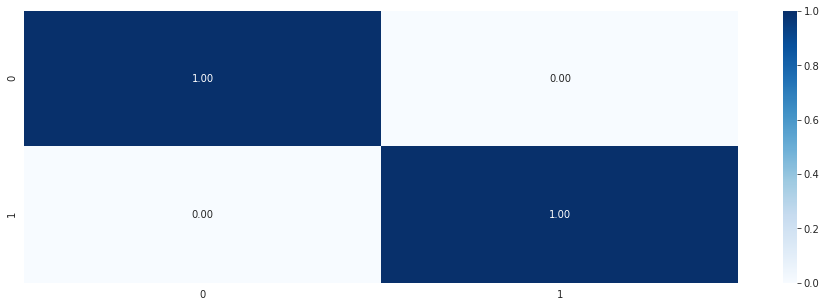

In [11]:
f = plt.subplots(1, 1, figsize=(16, 5), sharex=True)
train_cnf_matrix = confusion_matrix(train['target'], [np.round(x) for x in train['preds_avg']])
train_cnf_matrix_norm = train_cnf_matrix / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=[0, 1], columns=[0, 1])
sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues")
plt.show()

## Metrics ROC AUC

In [12]:
print('QDA AUC %.2f' % roc_auc_score(train['target'], train['preds_qda']))
print('KNN AUC %.2f' % roc_auc_score(train['target'], train['preds_knn']))
print('MLP AUC %.2f' % roc_auc_score(train['target'], train['preds_mlp']))
print('SVC AUC %.2f' % roc_auc_score(train['target'], train['preds_svc']))
print('NuSVC AUC %.2f' % roc_auc_score(train['target'], train['preds_nusvc']))
print('Top 2 AUC %.2f' % roc_auc_score(train['target'], train['preds_top2']))
print('Top 3 AUC %.2f' % roc_auc_score(train['target'], train['preds_top3']))
print('Top 4 AUC %.2f' % roc_auc_score(train['target'], train['preds_top4']))
print('Averaged AUC %.2f' % roc_auc_score(train['target'], train['preds_avg']))

QDA AUC 0.99
KNN AUC 0.97
MLP AUC 1.00
SVC AUC 1.00
NuSVC AUC 1.00
Top 2 AUC 1.00
Top 3 AUC 1.00
Top 4 AUC 1.00
Averaged AUC 1.00


In [13]:
test[['id', 'target_avg', 'target_qda', 'target_knn', 'target_mlp', 'target_svc', 'target_nusvc']].head(10)

id      ...       target_nusvc
0  1c13f2701648e0b0d46d8a2a5a131a53      ...           0.728495
1  ba88c155ba898fc8b5099893036ef205      ...           0.507540
2  7cbab5cea99169139e7e6d8ff74ebb77      ...           0.426354
3  ca820ad57809f62eb7b4d13f5d4371a0      ...           0.610746
4  7baaf361537fbd8a1aaa2c97a6d4ccc7      ...           0.163546
5  8b3116e5e3e92e971dac305d1a093bf6      ...           0.001960
6  35cfd7cab9bfa29bc963d1b8c94dd280      ...           0.015433
7  83cf532df8ff4642a3e33a70fffdac37      ...           0.915184
8  2e1350fe94ec9f2220bec5245e5e9265      ...           0.700012
9  e62020afa72eb54a15725473e3a8475b      ...           0.373050

[10 rows x 7 columns]

# Test predictions

In [14]:
submission = test[['id', 'target_avg']]
submission.columns = ['id', 'target']
submission.to_csv('submission_avg.csv', index=False)
submission.head(10)

id    target
0  1c13f2701648e0b0d46d8a2a5a131a53  0.688967
1  ba88c155ba898fc8b5099893036ef205  0.710274
2  7cbab5cea99169139e7e6d8ff74ebb77  0.379469
3  ca820ad57809f62eb7b4d13f5d4371a0  0.367808
4  7baaf361537fbd8a1aaa2c97a6d4ccc7  0.308333
5  8b3116e5e3e92e971dac305d1a093bf6  0.110309
6  35cfd7cab9bfa29bc963d1b8c94dd280  0.017653
7  83cf532df8ff4642a3e33a70fffdac37  0.955964
8  2e1350fe94ec9f2220bec5245e5e9265  0.741463
9  e62020afa72eb54a15725473e3a8475b  0.172382

In [15]:
submission = test[['id', 'target_top2']]
submission.columns = ['id', 'target']
submission.to_csv('submission_top2.csv', index=False)
submission.head(10)

id    target
0  1c13f2701648e0b0d46d8a2a5a131a53  0.864233
1  ba88c155ba898fc8b5099893036ef205  0.747758
2  7cbab5cea99169139e7e6d8ff74ebb77  0.213177
3  ca820ad57809f62eb7b4d13f5d4371a0  0.343007
4  7baaf361537fbd8a1aaa2c97a6d4ccc7  0.300821
5  8b3116e5e3e92e971dac305d1a093bf6  0.000980
6  35cfd7cab9bfa29bc963d1b8c94dd280  0.007717
7  83cf532df8ff4642a3e33a70fffdac37  0.957592
8  2e1350fe94ec9f2220bec5245e5e9265  0.849860
9  e62020afa72eb54a15725473e3a8475b  0.194327

In [16]:
submission = test[['id', 'target_top3']]
submission.columns = ['id', 'target']
submission.to_csv('submission_top3.csv', index=False)
submission.head(10)

id    target
0  1c13f2701648e0b0d46d8a2a5a131a53  0.776343
1  ba88c155ba898fc8b5099893036ef205  0.770957
2  7cbab5cea99169139e7e6d8ff74ebb77  0.242254
3  ca820ad57809f62eb7b4d13f5d4371a0  0.275965
4  7baaf361537fbd8a1aaa2c97a6d4ccc7  0.271403
5  8b3116e5e3e92e971dac305d1a093bf6  0.028637
6  35cfd7cab9bfa29bc963d1b8c94dd280  0.005437
7  83cf532df8ff4642a3e33a70fffdac37  0.969654
8  2e1350fe94ec9f2220bec5245e5e9265  0.767031
9  e62020afa72eb54a15725473e3a8475b  0.152960

In [17]:
submission = test[['id', 'target_top4']]
submission.columns = ['id', 'target']
submission.to_csv('submission_top4.csv', index=False)
submission.head(10)

id    target
0  1c13f2701648e0b0d46d8a2a5a131a53  0.765754
1  ba88c155ba898fc8b5099893036ef205  0.737842
2  7cbab5cea99169139e7e6d8ff74ebb77  0.269791
3  ca820ad57809f62eb7b4d13f5d4371a0  0.355214
4  7baaf361537fbd8a1aaa2c97a6d4ccc7  0.280870
5  8b3116e5e3e92e971dac305d1a093bf6  0.024250
6  35cfd7cab9bfa29bc963d1b8c94dd280  0.022066
7  83cf532df8ff4642a3e33a70fffdac37  0.958592
8  2e1350fe94ec9f2220bec5245e5e9265  0.726829
9  e62020afa72eb54a15725473e3a8475b  0.160932

In [18]:
submission = test[['id', 'target_qda']]
submission.columns = ['id', 'target']
submission.to_csv('submission_qda.csv', index=False)
submission.head(10)

id        target
0  1c13f2701648e0b0d46d8a2a5a131a53  9.999712e-01
1  ba88c155ba898fc8b5099893036ef205  9.879759e-01
2  7cbab5cea99169139e7e6d8ff74ebb77  2.529365e-07
3  ca820ad57809f62eb7b4d13f5d4371a0  7.526842e-02
4  7baaf361537fbd8a1aaa2c97a6d4ccc7  4.380961e-01
5  8b3116e5e3e92e971dac305d1a093bf6  2.969658e-08
6  35cfd7cab9bfa29bc963d1b8c94dd280  5.630912e-10
7  83cf532df8ff4642a3e33a70fffdac37  9.999995e-01
8  2e1350fe94ec9f2220bec5245e5e9265  9.997077e-01
9  e62020afa72eb54a15725473e3a8475b  1.560315e-02

In [19]:
submission = test[['id', 'target_knn']]
submission.columns = ['id', 'target']
submission.to_csv('submission_knn.csv', index=False)
submission.head(10)

id    target
0  1c13f2701648e0b0d46d8a2a5a131a53  0.381818
1  ba88c155ba898fc8b5099893036ef205  0.600000
2  7cbab5cea99169139e7e6d8ff74ebb77  0.818182
3  ca820ad57809f62eb7b4d13f5d4371a0  0.418182
4  7baaf361537fbd8a1aaa2c97a6d4ccc7  0.418182
5  8b3116e5e3e92e971dac305d1a093bf6  0.454545
6  35cfd7cab9bfa29bc963d1b8c94dd280  0.000000
7  83cf532df8ff4642a3e33a70fffdac37  0.945455
8  2e1350fe94ec9f2220bec5245e5e9265  0.800000
9  e62020afa72eb54a15725473e3a8475b  0.218182

In [20]:
submission = test[['id', 'target_mlp']]
submission.columns = ['id', 'target']
submission.to_csv('submission_mlp.csv', index=False)
submission.head(10)

id    target
0  1c13f2701648e0b0d46d8a2a5a131a53  0.571265
1  ba88c155ba898fc8b5099893036ef205  0.825089
2  7cbab5cea99169139e7e6d8ff74ebb77  0.310101
3  ca820ad57809f62eb7b4d13f5d4371a0  0.119533
4  7baaf361537fbd8a1aaa2c97a6d4ccc7  0.202762
5  8b3116e5e3e92e971dac305d1a093bf6  0.093169
6  35cfd7cab9bfa29bc963d1b8c94dd280  0.000119
7  83cf532df8ff4642a3e33a70fffdac37  0.997800
8  2e1350fe94ec9f2220bec5245e5e9265  0.573764
9  e62020afa72eb54a15725473e3a8475b  0.056438

In [21]:
submission = test[['id', 'target_svc']]
submission.columns = ['id', 'target']
submission.to_csv('submission_svc.csv', index=False)
submission.head(10)

id    target
0  1c13f2701648e0b0d46d8a2a5a131a53  0.763283
1  ba88c155ba898fc8b5099893036ef205  0.630764
2  7cbab5cea99169139e7e6d8ff74ebb77  0.342708
3  ca820ad57809f62eb7b4d13f5d4371a0  0.615309
4  7baaf361537fbd8a1aaa2c97a6d4ccc7  0.319077
5  8b3116e5e3e92e971dac305d1a093bf6  0.001869
6  35cfd7cab9bfa29bc963d1b8c94dd280  0.072711
7  83cf532df8ff4642a3e33a70fffdac37  0.921384
8  2e1350fe94ec9f2220bec5245e5e9265  0.633831
9  e62020afa72eb54a15725473e3a8475b  0.198638

In [22]:
submission = test[['id', 'target_nusvc']]
submission.columns = ['id', 'target']
submission.to_csv('submission_nusvc.csv', index=False)
submission.head(10)

id    target
0  1c13f2701648e0b0d46d8a2a5a131a53  0.728495
1  ba88c155ba898fc8b5099893036ef205  0.507540
2  7cbab5cea99169139e7e6d8ff74ebb77  0.426354
3  ca820ad57809f62eb7b4d13f5d4371a0  0.610746
4  7baaf361537fbd8a1aaa2c97a6d4ccc7  0.163546
5  8b3116e5e3e92e971dac305d1a093bf6  0.001960
6  35cfd7cab9bfa29bc963d1b8c94dd280  0.015433
7  83cf532df8ff4642a3e33a70fffdac37  0.915184
8  2e1350fe94ec9f2220bec5245e5e9265  0.700012
9  e62020afa72eb54a15725473e3a8475b  0.373050